In [ ]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx

import matplotlib.pyplot as plt

In [ ]:
!python3 -m spacy download en_core_web_sm

In [ ]:
# Load spacy English languague model
NER = spacy.load("en_core_web_sm")

## Load books

In [ ]:
import os
 
# Get all book files in the data directory
all_books = [b for b in os.scandir('data') if '.txt' in b.name]

In [ ]:
all_books

In [ ]:
book = all_books[1]
# book = cryptojacking
book_text = open(book).read()
print(book_text)

In [ ]:
all_entities = NER(book_text)

In [46]:
entity_types_to_remove = ["CARDINAL", "TIME", "DATE", "ORDINAL", "QUANTITY", "PERCENT", "MONEY"]
filtered_entities =[ent.text for ent in all_entities.ents if ent.label_ not in entity_types_to_remove]
print(filtered_entities)

['Problem', 'Amazon Web Services\nSecurity', 'EleKtra-Leak', 'GitHub', 'Amazon Elastic Compute Cloud', 'Monero', 'AWS', 'AWS', 'Cyber', 'GitHub', 'AWS', 'API', 'CloudTrail', 'AWS', 'Monero', 'Google Drive', 'Google Drive', 'Monero', 'AWS', 'Cybersecurity', 'GitHub', 'API', 'EleKtra-Leak', 'Monero', 'GitHub', 'GitHub', 'Settings', 'Settings', 'Security', 'The Recommendation\nEnable', 'The Special Note\nNow', 'GitHub', 'GitHub', 'The Closing\nRemember', 'AI', 'AWS', 'the Next Level', 'Digital Cloud Training', 'Digital Cloud Training', 'Cloud Computing', 'Lambda', 'Boto3\nLinux File System', 'Cloud Computing', 'AMBERSQUID', 'AWS Amplify', 'Amazon SageMaker', 'Amazon Elastic Compute Cloud', 'Amazon', 'AWS', 'Sysdig', 'Sysdig', 'Linux', 'Docker Hub', 'GitHub', 'Indonesia', 'AWS', 'Docker', 'AWS', 'CodeCommit', 'SageMaker', 'Amazon Elastic Container Service', 'Amazon ECS', 'Docker', 'CodeCommit', 'Git', 'AWS', 'Git', 'AWS Amplify', 'Amazon ECS', 'Amazon', 'ECS', 'AWS Fargate', 'GB', 'RAM', '

In [ ]:
# Visualize identified entities
displacy.render(all_entities[0:2000], style="ent", jupyter=True)

## Get named entity list per sentence

In [58]:
sent_entity_df = []

# Loop through sentences, store named entity list for each sentence
for sent in all_entities.sents:
    entity_list = [ent.text for ent in sent.ents if ent.label_ not in entity_types_to_remove]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)
print(sent_entity_df.head(10))

                                            sentence  \
0  (﻿The, Problem, \n, Amazon, Web, Services, \n,...   
1  (In, this, cyber, odyssey, ,, mischievous, cul...   
2  (Specifically, ,, key, pairs, are, used, to, a...   
3  (The, “, clone, and, exploit, ”, happens, with...   
4  (They, then, unleash, a, legion, of, Amazon, E...   
5  (Researchers, witnessed, a, staggering, 474, m...   
6  (AWS, tries, to, help, with, its, security, pr...   
7  (If, AWS, determines, a, key, pair, has, been,...   
8  ((, Note, :, If, you, get, an, email, from, AW...   
9  (However, ,, our, hackers, are, very, good, at...   

                                            entities  
0  [Problem, Amazon Web Services\nSecurity, EleKt...  
1                                           [GitHub]  
2                                                 []  
3                                                 []  
4             [Amazon Elastic Compute Cloud, Monero]  
5                                                 [] 

In [60]:
sent_entity_df

,sentence,entities
0,"(﻿The, Problem, \n, Amazon, Web, Services, \n,...","[Problem, Amazon Web Services\nSecurity, EleKt..."
1,"(In, this, cyber, odyssey, ,, mischievous, cul...",[GitHub]
2,"(Specifically, ,, key, pairs, are, used, to, a...",[]
3,"(The, “, clone, and, exploit, ”, happens, with...",[]
4,"(They, then, unleash, a, legion, of, Amazon, E...","[Amazon Elastic Compute Cloud, Monero]"
5,"(Researchers, witnessed, a, staggering, 474, m...",[]
6,"(AWS, tries, to, help, with, its, security, pr...",[]
7,"(If, AWS, determines, a, key, pair, has, been,...",[AWS]
8,"((, Note, :, If, you, get, an, email, from, AW...",[AWS]
9,"(However, ,, our, hackers, are, very, good, at...",[]


In [70]:
# Filter out sentences that don't have any entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['entities'].map(len) > 0]
sent_entity_df_filtered.head(10)

,sentence,entities,character_entities
0,"(﻿The, Problem, \n, Amazon, Web, Services, \n,...","[Problem, Amazon Web Services\nSecurity, EleKt...","[Problem, Amazon Web Services\nSecurity, EleKt..."
1,"(In, this, cyber, odyssey, ,, mischievous, cul...",[GitHub],[GitHub]
4,"(They, then, unleash, a, legion, of, Amazon, E...","[Amazon Elastic Compute Cloud, Monero]","[Amazon Elastic Compute Cloud, Monero]"
7,"(If, AWS, determines, a, key, pair, has, been,...",[AWS],[AWS]
8,"((, Note, :, If, you, get, an, email, from, AW...",[AWS],[AWS]
11,"(Cyber, researchers, have, confirmed, that, th...","[Cyber, GitHub]","[Cyber, GitHub]"
14,"(Once, they, get, their, grubby, hands, on, AW...",[AWS],[AWS]
17,"(In, a, synchronized, dance, across, multiple,...","[API, CloudTrail]","[API, CloudTrail]"
18,"(All, this, is, done, by, hiding, as, much, as...",[AWS],[AWS]
22,"(Because, when, you, ’re, cryptojacking, ,, yo...",[Monero],[Monero]


In [71]:
pd.reset_option('^display.', silent=True)
sent_entity_df_filtered

,sentence,entities,character_entities
0,"(﻿The, Problem, \n, Amazon, Web, Services, \n,...","[Problem, Amazon Web Services\nSecurity, EleKt...","[Problem, Amazon Web Services\nSecurity, EleKt..."
1,"(In, this, cyber, odyssey, ,, mischievous, cul...",[GitHub],[GitHub]
4,"(They, then, unleash, a, legion, of, Amazon, E...","[Amazon Elastic Compute Cloud, Monero]","[Amazon Elastic Compute Cloud, Monero]"
7,"(If, AWS, determines, a, key, pair, has, been,...",[AWS],[AWS]
8,"((, Note, :, If, you, get, an, email, from, AW...",[AWS],[AWS]
...,...,...,...
163,"(Subsequently, ,, the, attackers, continued, t...","[Subsequently, GitHub]","[Subsequently, GitHub]"
165,"(Instead, ,, they, downloaded, cryptocurrency,...","[GitHub, Docker]","[GitHub, Docker]"
167,"(These, binaries, are, usually, labeled, as, ""...",[UPX],[UPX]
168,"(The, attack, has, been, moderately, attribute...","[Indonesia, Indonesian]","[Indonesia, Indonesian]"


## Create relationships

In [72]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [73]:
relationship_df = pd.DataFrame(relationships)

In [74]:
pd.set_option('display.max_rows', None)
relationship_df

,source,target
0,Problem,Amazon Web Services\nSecurity
1,Amazon Web Services\nSecurity,EleKtra-Leak
2,EleKtra-Leak,GitHub
3,GitHub,Amazon Elastic Compute Cloud
4,Amazon Elastic Compute Cloud,Monero
5,GitHub,Amazon Elastic Compute Cloud
6,Amazon Elastic Compute Cloud,Monero
7,Amazon Elastic Compute Cloud,Monero
8,Monero,AWS
9,Amazon Elastic Compute Cloud,Monero


In [75]:
# Sort the cases with a->b and b->a
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df

,source,target
0,Amazon Web Services\nSecurity,Problem
1,Amazon Web Services\nSecurity,EleKtra-Leak
2,EleKtra-Leak,GitHub
3,Amazon Elastic Compute Cloud,GitHub
4,Amazon Elastic Compute Cloud,Monero
5,Amazon Elastic Compute Cloud,GitHub
6,Amazon Elastic Compute Cloud,Monero
7,Amazon Elastic Compute Cloud,Monero
8,AWS,Monero
9,Amazon Elastic Compute Cloud,Monero


In [76]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [77]:
relationship_df.head(10)

,source,target,value
0,Amazon Web Services\nSecurity,Problem,1
1,Amazon Web Services\nSecurity,EleKtra-Leak,1
2,EleKtra-Leak,GitHub,6
3,Amazon Elastic Compute Cloud,GitHub,7
4,Amazon Elastic Compute Cloud,Monero,11
5,AWS,Monero,8
6,AWS,Cyber,3
7,Cyber,GitHub,6
8,AWS,GitHub,36
9,API,AWS,9


## Graph analysis and visualization

In [78]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

#### Graph visualization - Networkx

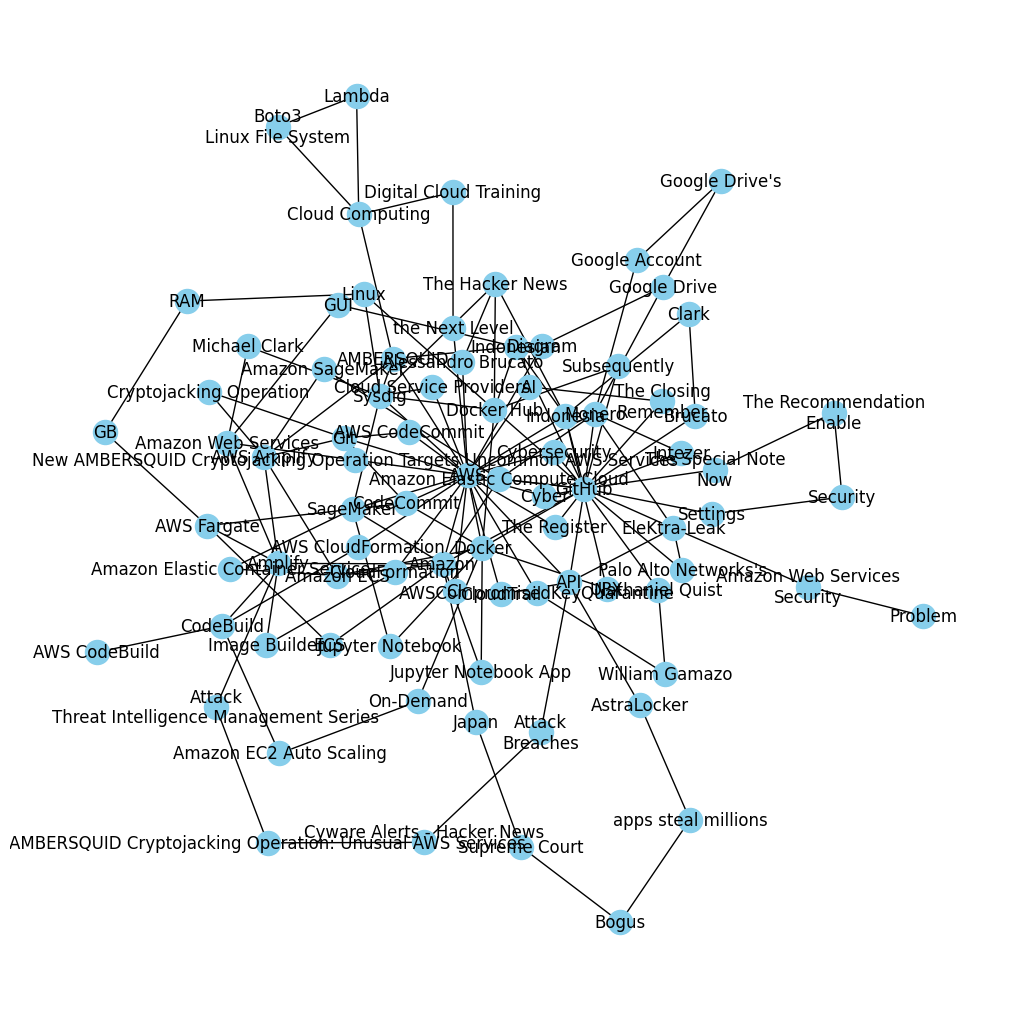

In [79]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

#### Graph visualization - Pyvis

In [81]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("witcher.html")

witcher.html


### The most important characters in The Witcher

In [82]:
# Degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict

{'Amazon Web Services\nSecurity': 0.024096385542168676,
 'Problem': 0.012048192771084338,
 'EleKtra-Leak': 0.060240963855421686,
 'GitHub': 0.2530120481927711,
 'Amazon Elastic Compute Cloud': 0.04819277108433735,
 'Monero': 0.08433734939759037,
 'AWS': 0.3132530120481928,
 'Cyber': 0.024096385542168676,
 'API': 0.07228915662650603,
 'CloudTrail': 0.024096385542168676,
 'Google Drive': 0.03614457831325302,
 'Cybersecurity': 0.024096385542168676,
 'Settings': 0.024096385542168676,
 'Security': 0.024096385542168676,
 'The Recommendation\nEnable': 0.024096385542168676,
 'The Special Note\nNow': 0.024096385542168676,
 'The Closing\nRemember': 0.024096385542168676,
 'AI': 0.024096385542168676,
 'the Next Level': 0.024096385542168676,
 'Digital Cloud Training': 0.024096385542168676,
 'Cloud Computing': 0.04819277108433735,
 'Lambda': 0.024096385542168676,
 'Boto3\nLinux File System': 0.024096385542168676,
 'AMBERSQUID': 0.060240963855421686,
 'AWS Amplify': 0.07228915662650603,
 'Amazon Sage

<Axes: >

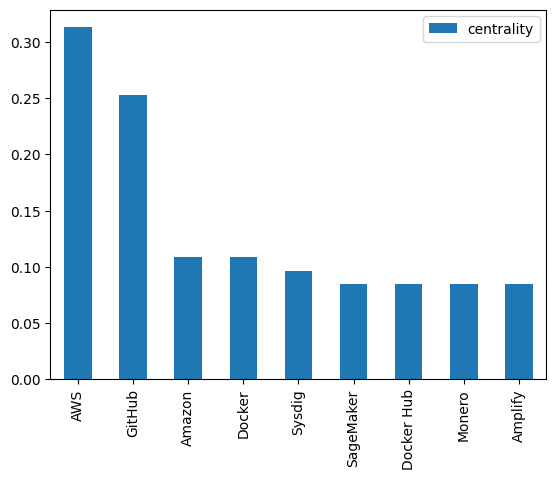

In [83]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<Axes: >

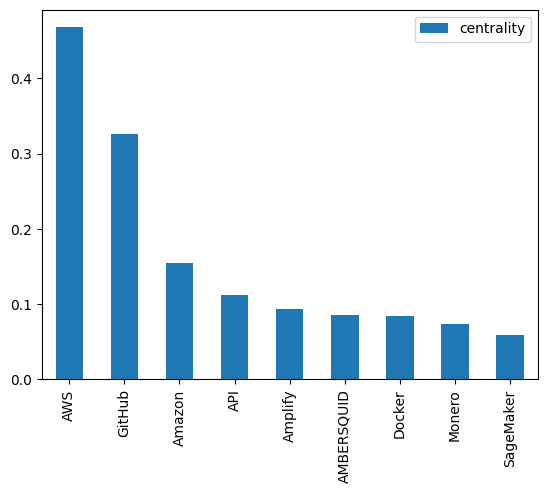

In [84]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<Axes: >

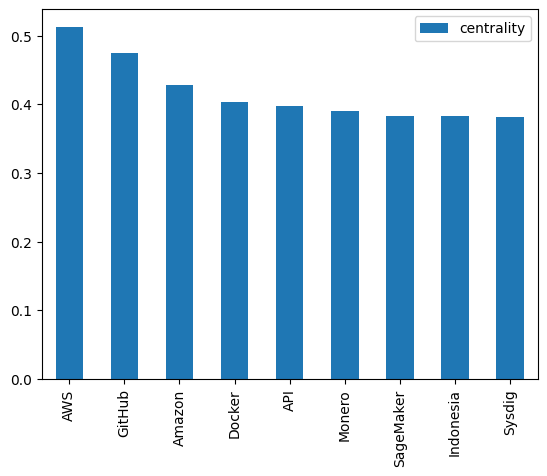

In [85]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

In [96]:
# Save centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

In [98]:
!pip install python-louvain

3460.69s - pydevd: Sending message related to process being replaced timed-out after 5 seconds

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


### Community detection

In [104]:
from community import community_louvain

In [105]:
communities = community_louvain.best_partition(G)

In [106]:
communities

{'Amazon Web Services\nSecurity': 0,
 'Problem': 0,
 'EleKtra-Leak': 0,
 'GitHub': 0,
 'Amazon Elastic Compute Cloud': 1,
 'Monero': 1,
 'AWS': 2,
 'Cyber': 0,
 'API': 3,
 'CloudTrail': 3,
 'Google Drive': 1,
 'Cybersecurity': 0,
 'Settings': 0,
 'Security': 0,
 'The Recommendation\nEnable': 0,
 'The Special Note\nNow': 0,
 'The Closing\nRemember': 0,
 'AI': 0,
 'the Next Level': 5,
 'Digital Cloud Training': 5,
 'Cloud Computing': 5,
 'Lambda': 5,
 'Boto3\nLinux File System': 5,
 'AMBERSQUID': 6,
 'AWS Amplify': 2,
 'Amazon SageMaker': 1,
 'Amazon': 2,
 'Sysdig': 6,
 'Linux': 6,
 'Docker Hub': 6,
 'Indonesia': 6,
 'Docker': 2,
 'CodeCommit': 2,
 'SageMaker': 2,
 'Amazon Elastic Container Service': 2,
 'Amazon ECS': 2,
 'Git': 2,
 'ECS': 2,
 'AWS Fargate': 2,
 'GB': 6,
 'RAM': 6,
 'AWS CodeBuild': 4,
 'CodeBuild': 4,
 'AWS CloudFormation': 4,
 'CloudFormation': 2,
 'Image Builder': 2,
 'Amplify': 2,
 'Amazon EC2 Auto Scaling': 4,
 'On-Demand': 4,
 'Jupyter Notebook App': 2,
 'Jupyter N

In [107]:
nx.set_node_attributes(G, communities, 'group')

In [117]:
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show("witcher_communities.html")

TypeError: Network.show() got an unexpected keyword argument 'cdn_resources'

### Evolution of characters' importance

In [110]:
from lib.utils.functions import *

In [111]:
# Initialize empty list for graphs from books
books_graph = []
all_books = [b for b in os.scandir('data') if '.txt' in b.name]
# Load spacy English languague model
nlp = spacy.load("en_core_web_sm")

# Sort dir entries by name
all_books.sort(key=lambda x: x.name)

In [114]:
# Loop through book list and create graphs
for book in all_books:
    book_text = ner(book)
    
    # Get list of entities per sentences
    sent_entity_df = get_ne_list_per_sentence(book_text)
    

    # Filter out sentences that don't have any character entities
    sent_entity_df_filtered = sent_entity_df[sent_entity_df['entities'].map(len) > 0]                                                                                                               for item in x])

    # Create relationship df
    relationship_df = create_relationships(df = sent_entity_df_filtered, window_size = 5)                                                                                                               
    
    # Create a graph from a pandas dataframe
    G = nx.from_pandas_edgelist(relationship_df, 
                                source = "source", 
                                target = "target", 
                                edge_attr = "value", 
                                create_using = nx.Graph())     
    
    books_graph.append(G) 

SyntaxError: unmatched ']' (2404166697.py, line 10)

In [115]:
# Creating a list of degree centrality of all the books
evol = [nx.degree_centrality(book) for book in books_graph]

# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_df = pd.DataFrame.from_records(evol)

# Plotting the degree centrality evolution of 5 main characters
degree_evol_df[["Geralt", "Ciri", "Yennefer", "Dandelion", "Vesemir"]].plot()

KeyError: "['Ciri', 'Dandelion'] not in index"